In [16]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!pip install box2d-py

In [4]:
env = gym.make('LunarLander-v2')

In [5]:
env.reset()

array([ 0.00550089,  1.4009429 ,  0.557158  , -0.44343776, -0.0063673 ,
       -0.1262046 ,  0.        ,  0.        ], dtype=float32)

In [6]:
prev_screen = env.render(mode='rgb_array')

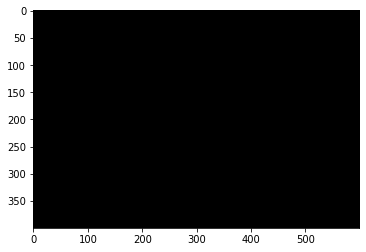

In [7]:
plt.imshow(prev_screen)

In [9]:
for i in range(200):
    env.render()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
env.close()

In [13]:
class ActorNet(nn.Module):
    def __init__(self, state_Size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = torch.clamp(x, -1.1, 1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.out(x), dim=-1)

In [23]:
class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, learning_rate, discount):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.actor_net.parameters(), lr=learning_rate)
        self.discount = discount
        
    def select_action(self, state):
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action
    
    def train(self, state_list, action_list, reward_list):
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len - 1, -1, -1):
            g_return = reward_list[i] + self.discount * g_return
            return_array[i] = g_return
        
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1, 1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1, 1)
        
        selected_action_probs = self.actor_net(state_t).gather(1, action_t)
        loss = torch.mean(-torch.log(selected_action_probs) * return_t)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.detach().cpu().numpy()

In [27]:
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
episodes = 5000
hidden_size = 256
learning_rate = 0.0005
discount = 0.99
reward_scale = 0.01

agent = PGAgent(state_size, action_size, hidden_size, learning_rate, discount)

In [28]:
stats_rewards_list = []
stats_every = 10
total_reward = 0
timesteps = 0
episode_length = 0

for ep in range(episodes):
    state = env.reset()
    stats_loss = 0.
    
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:], axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".format(ep, np.mean(stats_rewards_list[-stats_every:], axis=0)[1], stats_every))
        break
    
    state_list = []
    action_list = []
    reward_list = []
    
    while True:
        timesteps += 1
        env.render()
        action = agent.select_action(state)
        
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward * reward_scale)
        
        if total_reward < -250:
            done = 1
            
        if done:
            stats_loss += agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0
            if ep % stats_every == 0:
                print('Episode {}'.format(ep),
                     'Timestep: {}'.format(timesteps),
                     'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:], axis=0)[1]),
                     'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:], axis=0)[2]),
                     'Loss: {:.3f}'.format(stats_loss/stats_every))
            break
            
        state = next_state

Episode 0 Timestep: 58 Total reward: -112.2 Episode length: 58.0 Loss: -0.102
Episode 10 Timestep: 943 Total reward: -192.9 Episode length: 88.5 Loss: -0.211
Episode 20 Timestep: 1936 Total reward: -121.6 Episode length: 99.3 Loss: -0.055
Episode 30 Timestep: 2909 Total reward: -198.3 Episode length: 97.3 Loss: -0.098
Episode 40 Timestep: 4165 Total reward: -165.9 Episode length: 125.6 Loss: -0.137
Episode 50 Timestep: 5294 Total reward: -217.4 Episode length: 112.9 Loss: -0.060
Episode 60 Timestep: 6502 Total reward: -172.1 Episode length: 120.8 Loss: -0.087
Episode 70 Timestep: 7493 Total reward: -158.8 Episode length: 99.1 Loss: -0.065
Episode 80 Timestep: 8444 Total reward: -180.0 Episode length: 95.1 Loss: -0.126
Episode 90 Timestep: 9467 Total reward: -159.7 Episode length: 102.3 Loss: -0.080
Episode 100 Timestep: 10466 Total reward: -138.2 Episode length: 99.9 Loss: -0.064
Episode 110 Timestep: 11406 Total reward: -158.3 Episode length: 94.0 Loss: -0.179
Episode 120 Timestep: 12

Episode 990 Timestep: 236477 Total reward: 2.6 Episode length: 787.1 Loss: -0.005
Episode 1000 Timestep: 244062 Total reward: 4.6 Episode length: 758.5 Loss: 0.004
Episode 1010 Timestep: 252541 Total reward: -1.5 Episode length: 847.9 Loss: -0.007
Episode 1020 Timestep: 257666 Total reward: 6.0 Episode length: 512.5 Loss: -0.004
Episode 1030 Timestep: 264017 Total reward: -3.4 Episode length: 635.1 Loss: -0.011


KeyboardInterrupt: 

In [30]:
env.close()